In [1]:
import math
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy.special import jv
import IPython.display as ipd

from utils import *
from estimated_noise import *

"""Speech Enhancement using A Spectral Amplitude Estimator"""

c:\ProgramData\anaconda3\envs\ex\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
c:\ProgramData\anaconda3\envs\ex\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


'Speech Enhancement using A Spectral Amplitude Estimator'

In [2]:
SAMPLE_RATE = 16000

target, sr = librosa.load('./assets/clean_speech.wav', sr=SAMPLE_RATE)
input_signal, sr = librosa.load('./assets/noisy_wav.wav', sr=SAMPLE_RATE)


maxPosteriorSNR= 100   
minPosteriorSNR= 1

NFFT=512
hop_length_sample = 256 
winfunc = 'hann'

smoothFactorDD=0.99

# the variance of the speech; lambda_x(k)  ->  noisy
stft_noisy_test = librosa.stft(input_signal, n_fft=NFFT, hop_length=hop_length_sample, win_length=NFFT, window=winfunc)
   
noisy_mag, noisy_phase = np.abs(stft_noisy_test), np.exp(1.j * np.angle(stft_noisy_test))
    
noisy_power = np.power(noisy_mag,2)

print(noisy_mag.shape)
print(noisy_phase.shape)
print(noisy_power.shape)


(257, 251)
(257, 251)
(257, 251)


In [3]:
# estimate the variance of the noise using minimum statistics noise PSD estimation ; lambda_d(k). 
estNoise = estnoisem(noisy_power, hop_length_sample/sr)     
estNoise = estNoise

aPosterioriSNR = noisy_power/estNoise                    

aPosterioriSNR[aPosterioriSNR > maxPosteriorSNR] = maxPosteriorSNR
aPosterioriSNR[aPosterioriSNR < minPosteriorSNR] = minPosteriorSNR

previousGainedaPosSNR=1 
(nFrames,nFFT2) = noisy_power.shape                
totalGain =[]
for i in range(nFFT2):                         
    aPosterioriSNR_frame = aPosterioriSNR[:,i]                  
    
    #operator [2](52)
    oper=aPosterioriSNR_frame-1
    oper[oper < 0] = 0 
    smoothed_a_priori_SNR = smoothFactorDD * previousGainedaPosSNR + (1-smoothFactorDD) * oper
    
    #V for MMSE estimate ([2](8)) 
    V=smoothed_a_priori_SNR*aPosterioriSNR_frame/(1+smoothed_a_priori_SNR)            
    
    #Calculate Gain function which results from the MMSE [2](7),(12).
    gain= smoothed_a_priori_SNR/(1+smoothed_a_priori_SNR)  
    if any(V<1):
        gain[V<1] = (math.gamma(1.5) * np.sqrt(V[V<1])) / aPosterioriSNR_frame[V<1] * np.exp(-1 * V[V<1] / 2) * ((1 + V[V<1]) * bessel(0, V[V<1] / 2) + V[V<1] * bessel(1, V[V<1] / 2))
    
    previousGainedaPosSNR = (gain**2) * aPosterioriSNR_frame
    totalGain.append(gain)
    
totalGain=np.array(totalGain)

print(totalGain.shape)

(251, 257)


In [4]:
# clean magnitude estimation
magnitude_estimated_clean = totalGain.T * noisy_mag

# using noisy signal's phase
reconstructed = magnitude_estimated_clean * noisy_phase
print(reconstructed.shape)

# ISTFT:  STFT --> ISTFT
signal_reconstructed_clean =librosa.istft(reconstructed, n_fft=NFFT, hop_length=hop_length_sample, win_length=NFFT, window=winfunc)


(257, 251)


In [5]:
ipd.Audio(signal_reconstructed_clean, rate=sr)
print(sr)
import scipy.io.wavfile as wav

wav.write("reconstructed_clean.wav",  sr, signal_reconstructed_clean)

16000


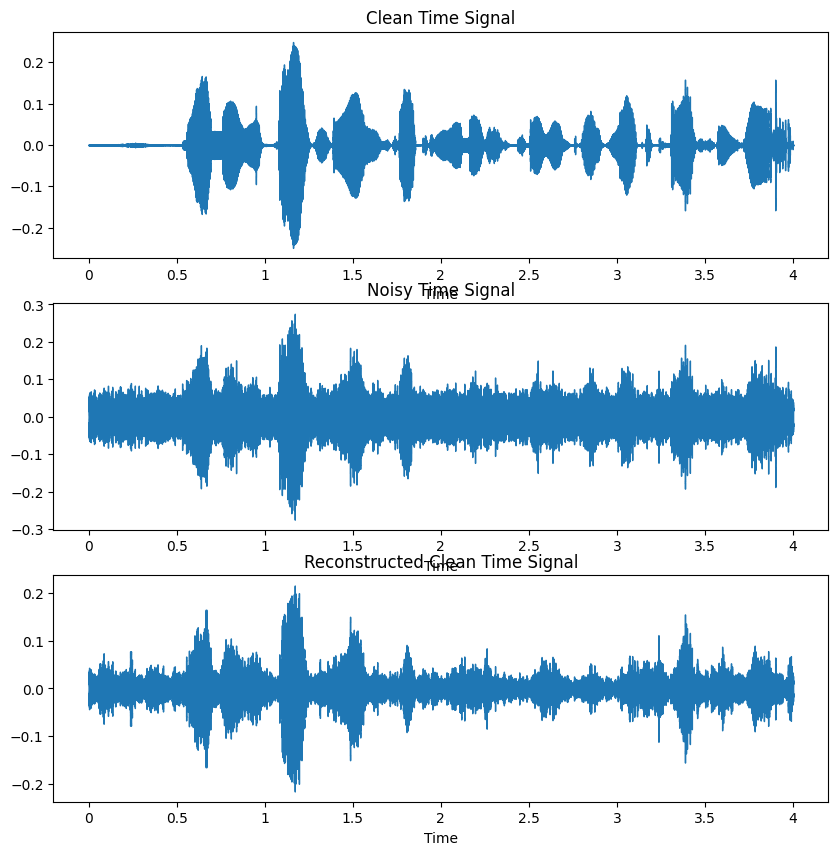

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [6]:
show_signal(target, input_signal, signal_reconstructed_clean, sr)